In [1]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM


In [2]:
df = pd.read_csv("../../Data/MSCI_World_Data.csv")

In [3]:
def convert_stationary_variables(df, var):  
    df[var] = df[var].diff()
    #df = df.dropna().reset_index(drop=True)
    return df
def convert_stationary_variables_with_log(df, var):  
    df[var] = df[var].apply(lambda x: np.log(x) if x > 0 else 0)
    df[var] = df[var].diff()
    #df = df.dropna().reset_index(drop=True)
    return df

In [4]:
df.head()


,timestamp,CL1,M1WO,SXXT,SPX,NKY,SPTR,EUR003M,FEDL01,GC1,V2X,MOVE,VIX,USYC2Y10,VXJ
0,2000-01-04,25.55,2779.67,494.31,1399.42,19002.86,1925.407,3.343,5.38,283.7,33.22,101.30,27.01,13.85,21.33
1,2000-01-05,24.91,2741.90,480.49,1402.11,18542.55,1929.278,3.341,5.41,282.1,32.59,106.69,26.41,29.55,26.00
2,2000-01-06,24.78,2710.88,477.33,1403.45,18168.27,1931.507,3.331,5.54,282.4,31.18,105.21,25.73,21.60,27.01
3,2000-01-07,24.22,2775.06,492.59,1441.47,18193.41,1983.832,3.322,5.61,282.9,27.44,97.81,21.72,15.60,25.73
4,2000-01-10,24.67,2805.83,500.17,1457.60,18193.41,2006.070,3.317,5.74,282.7,27.37,97.13,21.71,12.35,25.73


In [5]:
df.columns

Index(['timestamp', 'CL1', 'M1WO', 'SXXT', 'SPX', 'NKY', 'SPTR', 'EUR003M',
       'FEDL01', 'GC1', 'V2X', 'MOVE', 'VIX', 'USYC2Y10', 'VXJ'],
      dtype='object')

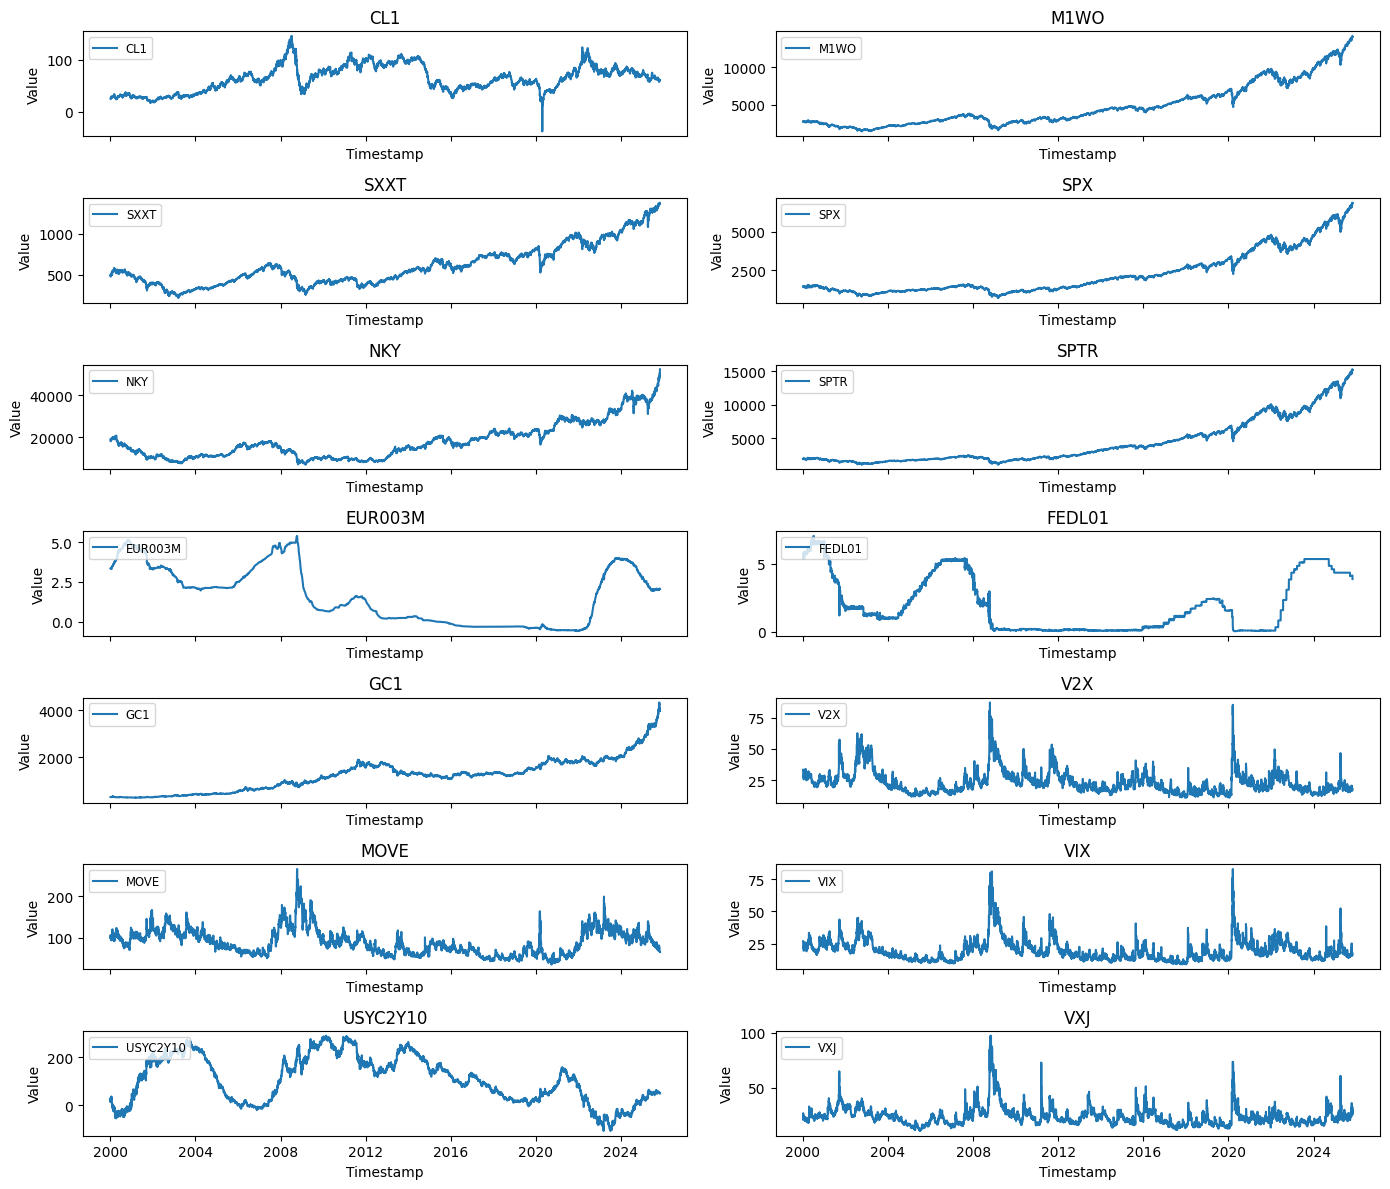

In [ ]:
import matplotlib.pyplot as plt

def plot_all_series(df, timestamp_col='timestamp', figsize=(14, 12)):
    """
    Plots all numeric columns in the DataFrame over time.
    
    Parameters:
        df (pd.DataFrame): DataFrame with time series data.
        timestamp_col (str): Name of the timestamp column.
        figsize (tuple): Figure size.
    """
    # Ensure timestamp is datetime
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])

    # Select only numeric columns (skip object/text columns)
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

    # Create subplots
    n_cols = 2
    n_rows = (len(numeric_cols) + 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=True)
    axes = axes.flatten()

    # Plot each variable
    for i, col in enumerate(numeric_cols):
        axes[i].plot(df[timestamp_col], df[col], label=col)
        axes[i].set_title(col)
        axes[i].set_xlabel('Timestamp')
        axes[i].set_ylabel('Value')
        axes[i].legend(loc='upper left', fontsize='small')

    # Remove empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_all_series(df)

In [7]:
def difference_over_variables(df,variables_dif = ('EUR003M',
       'FEDL01')  ,variables_log_dif = ('M1WO', 'NKY', 'SXXT','SPX','NKY','SPTR','GC1','CL1'), variables_log = ('V2X', 'MOVE', 'VIX', 'USYC2Y10', 'VXJ') ):
    for var in variables_log_dif:
        df = convert_stationary_variables_with_log(df, var)
    for var in variables_dif:
        df = convert_stationary_variables(df, var)
    for var in variables_log:
        df[var] = df[var].apply(lambda x: np.log(x) if x > 0 else 0)
    df = df.dropna().reset_index(drop=True)
    return df

df_diff = difference_over_variables(df)

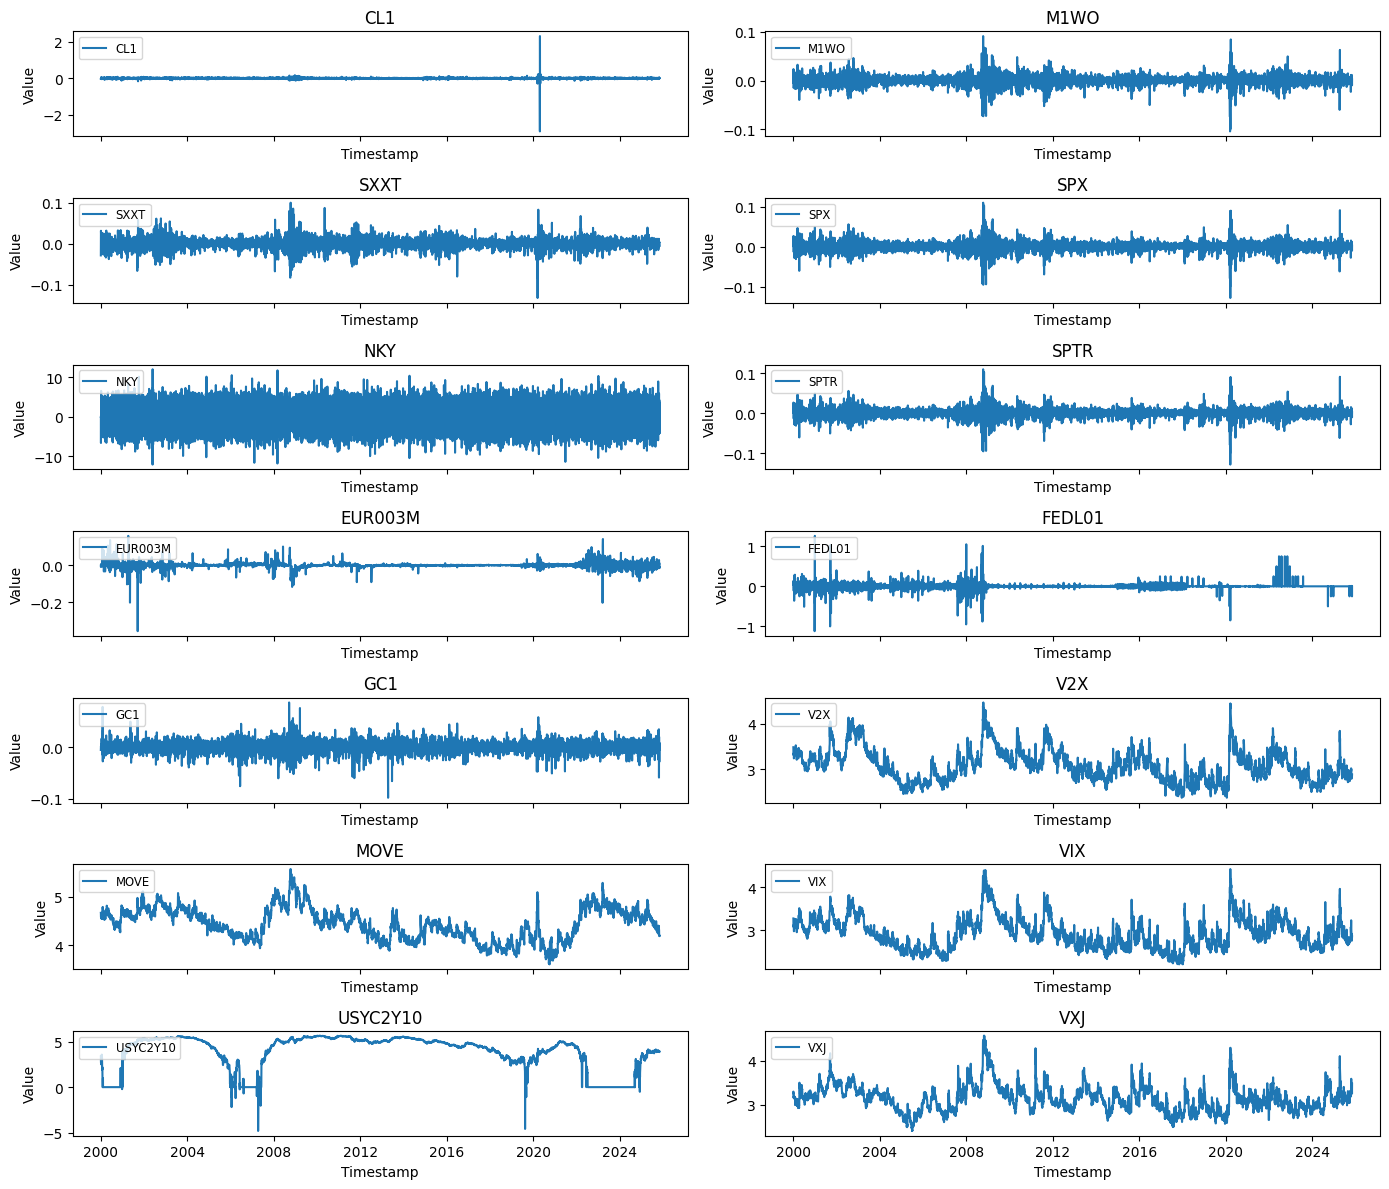

In [8]:
plot_all_series(df_diff)

In [9]:
def label_states(df_diff, variable='M1WO', n_states=2):
    returns = df_diff[variable].dropna().values.reshape(-1, 1)

    model = GaussianHMM(n_components=n_states, covariance_type='full', n_iter=1000) #full does not matter
    model.fit(returns)

    trans_mat = model.transmat_
    print("Transition matrix (rows sum to 1):")
    print(trans_mat)
    hidden_states = model.predict(returns)
    r = returns.reshape(-1)
    state_means = np.array([r[hidden_states == i].mean() for i in range(model.n_components)])
    state_stds  = np.array([r[hidden_states == i].std()  for i in range(model.n_components)])

    print("State means:", state_means)
    print("State stds: ", state_stds)

    eps = 1e-8  # avoid divide-by-zero
    scores = state_means / (state_stds + eps)

    bull_state = np.argmax(scores)
    bear_state = np.argmin(scores)

    print(f"Bull state: {bull_state}, Bear state: {bear_state}")

    df_states = df_diff.loc[df_diff[variable].notna()].copy()
    df_states['state'] = hidden_states
    df_states['regime'] = df_states['state'].map({bull_state: 'Bull', bear_state: 'Bear'})

    plt.figure(figsize=(12,6))
    plt.plot(df_states['timestamp'], df_states[variable], label='M1WO Returns', color='black')

    plt.fill_between(
        df_states['timestamp'], df_states[variable].min(), df_states[variable].max(),
        where=df_states['regime'] == 'Bear', color='red', alpha=0.25, label='Bear Regime'
    )
    plt.fill_between(
        df_states['timestamp'], df_states[variable].min(), df_states[variable].max(),
        where=df_states['regime'] == 'Bull', color='green', alpha=0.15, label='Bull Regime'
    )

    plt.title('M1WO: Bull & Bear Market Regimes (HMM)')
    plt.xlabel('Timestamp')
    plt.ylabel('M1WO Returns')
    plt.legend()
    plt.show()

    return df_states

Transition matrix (rows sum to 1):
[[0.98707758 0.01292242]
 [0.04168355 0.95831645]]
State means: [ 0.00071921 -0.00130947]
State stds:  [0.00637204 0.01724984]
Bull state: 0, Bear state: 1


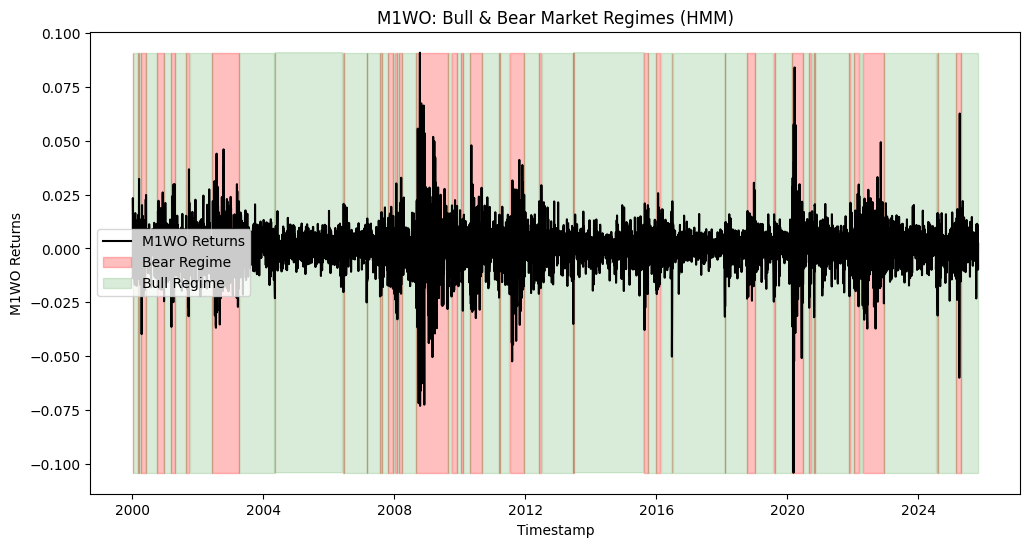

,timestamp,CL1,M1WO,SXXT,SPX,NKY,SPTR,EUR003M,FEDL01,GC1,V2X,MOVE,VIX,USYC2Y10,VXJ,state,regime
0,2000-01-05,-0.025368,-0.013681,-0.028356,0.001920,0.000000,0.002008,-0.002,0.03,-0.005656,3.484005,4.669927,3.273743,3.386084,3.258097,1,Bear
1,2000-01-06,-0.005232,-0.011378,-0.006598,0.000955,0.000000,0.001155,-0.010,0.13,0.001063,3.439777,4.655958,3.247658,3.072693,3.296207,1,Bear
2,2000-01-07,-0.022858,0.023399,0.031469,0.026730,-6.583663,0.026730,-0.009,0.07,0.001769,3.312002,4.583027,3.078233,2.747271,3.247658,1,Bear
3,2000-01-10,0.018409,0.011027,0.015271,0.011128,6.583663,0.011147,-0.005,0.13,-0.000707,3.309448,4.576050,3.077773,2.513656,3.247658,0,Bull
4,2000-01-11,0.043623,-0.003420,-0.004971,-0.013149,-3.338158,-0.013119,-0.002,-0.11,0.005995,3.330775,4.615418,3.113515,2.917771,3.151881,0,Bull
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6733,2025-10-27,-0.003094,0.010805,0.004416,0.012215,0.592428,0.012220,0.012,0.01,-0.028695,2.793794,4.202750,2.759377,3.889532,3.425890,0,Bull
6734,2025-10-28,-0.019102,0.001684,-0.000087,0.002285,3.717267,0.002290,-0.010,0.00,-0.008961,2.799547,4.209160,2.798500,3.879087,3.279406,0,Bull
6735,2025-10-29,0.005471,-0.000275,-0.000449,-0.000044,-3.842365,-0.000037,-0.008,0.00,0.004403,2.835241,4.185860,2.828496,3.862139,3.330775,0,Bull
6736,2025-10-30,0.001487,-0.009830,-0.001306,-0.009954,-4.115259,-0.009948,-0.016,-0.25,0.008050,2.825798,4.202900,2.827905,3.880863,3.249987,0,Bull


In [10]:

df_diff['timestamp'] = pd.to_datetime(df_diff['timestamp'])
label_states(df_diff)

In [11]:
df_diff.head()

,timestamp,CL1,M1WO,SXXT,SPX,NKY,SPTR,EUR003M,FEDL01,GC1,V2X,MOVE,VIX,USYC2Y10,VXJ
0,2000-01-05,-0.025368,-0.013681,-0.028356,0.001920,0.000000,0.002008,-0.002,0.03,-0.005656,3.484005,4.669927,3.273743,3.386084,3.258097
1,2000-01-06,-0.005232,-0.011378,-0.006598,0.000955,0.000000,0.001155,-0.010,0.13,0.001063,3.439777,4.655958,3.247658,3.072693,3.296207
2,2000-01-07,-0.022858,0.023399,0.031469,0.026730,-6.583663,0.026730,-0.009,0.07,0.001769,3.312002,4.583027,3.078233,2.747271,3.247658
3,2000-01-10,0.018409,0.011027,0.015271,0.011128,6.583663,0.011147,-0.005,0.13,-0.000707,3.309448,4.576050,3.077773,2.513656,3.247658
4,2000-01-11,0.043623,-0.003420,-0.004971,-0.013149,-3.338158,-0.013119,-0.002,-0.11,0.005995,3.330775,4.615418,3.113515,2.917771,3.151881
